BIDIRECTIONAL LSTM FOR 2 FEATURE DURATION 24 HOURS

Defining feature and duration

In [1]:
num_feature = 13
time_step = 24

Importing library

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Bidirectional, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder

Importing data

In [3]:
filename = '../data/07-09-2023.csv'
data = []
with open(filename, 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        data.append(row)
        
df = pd.DataFrame(data)
df.columns = ["Record_ID","Time","Timestamp","Temperature","Disolved Oxygen","Salinity","pH","Turbidity"]
df['Record_ID'] = df["Record_ID"].astype(int)
df['Time'] = df["Time"].astype(str)
df['Temperature'] = df["Temperature"].astype(float)
df['Disolved Oxygen'] = df["Disolved Oxygen"].astype(float)
df['Salinity'] = df["Salinity"].astype(float)
df['pH'] = df["pH"].astype(float)
df['Turbidity'] = df["Turbidity"].astype(float)
df['Time'] = pd.to_datetime(df['Time'],format="%d/%m/%Y %H:%M:%S")
df.set_index('Time', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.describe()

,Record_ID,Temperature,Disolved Oxygen,Salinity,pH,Turbidity
count,216701.000000,2.165460e+05,2.165460e+05,216546.000000,2.165460e+05,2.165460e+05
mean,510658.553103,-1.045808e+03,-1.066890e+03,28.388756,-1.066845e+03,-8.721180e+02
std,275942.121296,3.531911e+05,3.531911e+05,353.514121,3.531911e+05,3.531925e+05
min,1.000000,-1.162173e+08,-1.162173e+08,-116217.300000,-1.162173e+08,-1.162173e+08
25%,274897.000000,2.540000e+01,5.000000e+00,31.300000,6.600000e+00,1.380000e+01
50%,647845.000000,2.810000e+01,6.600000e+00,35.500000,7.200000e+00,2.810000e+01
75%,716179.000000,2.960000e+01,7.500000e+00,35.700000,7.800000e+00,8.200000e+01
max,843807.000000,4.430000e+01,2.972360e+04,47.800000,7.190000e+01,1.089990e+04


TEMPERATURE SECTION

In [4]:
temp = df['Temperature']
temp = temp[temp>=18]
temp = temp.resample('H').mean()

Splitting train and test data

In [5]:
train = temp[(temp.index.year<2022) | ((temp.index.year==2022)&(temp.index.month<9))]
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

In [6]:
month = np.array(train.index.month).reshape(-1,1)
encoder = OneHotEncoder()
month = encoder.fit(month).transform(month).toarray()
train = np.column_stack((train.to_numpy(), month)).reshape(-1,1,13)

month = np.array(test.index.month).reshape(-1,1)
month = encoder.fit(month).transform(month).toarray()
test = np.column_stack((test.to_numpy(), month)).reshape(-1,1,13)

In [7]:
def split_train(array: np.array, duration: int):
    x = np.empty((0,duration,num_feature))
    y = np.empty((0,1))
    for i in range(array.shape[0]-duration-1):
        new_row_x = array[i:i+duration,0,:].reshape(1, duration,num_feature)
        new_row_y = array[i+duration,0,0].reshape(1, 1)
        if (np.any(np.isnan(new_row_x)) or np.any(np.isnan(new_row_y))): continue
        else:
            x = np.concatenate((x,new_row_x),axis=0)
            y = np.concatenate((y,new_row_y),axis=0)
    return x.reshape(x.shape[0],x.shape[1],num_feature), y.reshape(y.shape[0],1)

Create and Training model

In [8]:
# model = Sequential()
# model.add(Bidirectional(LSTM(64,activation='relu', input_shape=(time_step,num_feature))))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# model.build(input_shape=(1,time_step,num_feature))
# model.summary()
# mse = 1
# x_train, y_train = split_train(train,time_step)
# x_test, y_test = split_train(test,time_step)
# while mse>0.17:
#     model.fit(x_train, y_train, epochs=10)
#     y_predict = np.array(model.predict(x_test))
#     y_predict = y_predict.ravel()
#     mse = mean_squared_error(y_test.ravel(), y_predict)
#     mae = mean_absolute_error(y_test.ravel(), y_predict)
#     print("Mean Squared Error (MSE):", mse)
#     print("Mean Absolute Error (MAE):", mae)
# model.save('./model/Bidirect-LSTM_24h_2feature_2.h5')

Load Model

In [9]:
model = load_model('../model/Bidirect-LSTM_24h_2feature.h5')
model.build(input_shape=(1,time_step,num_feature))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               39936     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 40065 (156.50 KB)
Trainable params: 40065 (156.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Predicting 1 hour ahead of 24 hour data point

267/267 [==============================] - 1s 3ms/step
Mean Squared Error (MSE): 0.17031479838870026
Mean Absolute Error (MAE): 0.24981490407030527
R Squared (R2): 0.9839435659208496


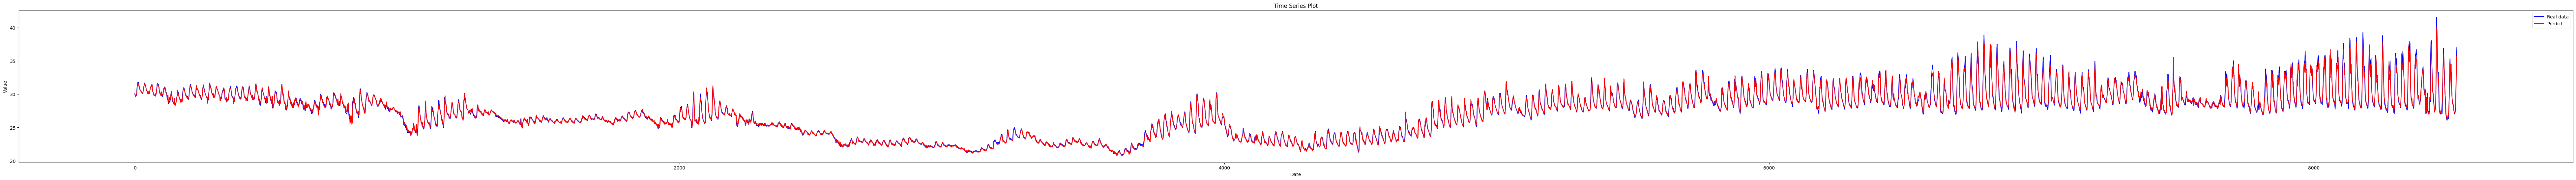

In [10]:
x_test, y_test = split_train(test,time_step)
y_predict = np.array(model.predict(x_test))
y_test = y_test.ravel()
y_predict = y_predict.ravel()
mse = mean_squared_error(y_test, y_predict)
mae = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R Squared (R2):", r2)
time = np.arange(len(y_predict))
plt.figure(figsize=(100,6))
plt.plot(time, y_test, label="Real data", color='blue')
plt.plot(time, y_predict, label="Predict",color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

Predicting 3 day ahead of 24 hour data point

In [11]:
def period_predict(array: np.array, hours_predict:int, time: np.array):
    y_hat = np.empty((array.shape[0],0))
    for i in range(hours_predict):
        y_hat = np.column_stack((y_hat,np.array(model.predict(array[:,i:,:])).reshape(-1,1)))
        time = time + np.timedelta64(1,'h')
        months = np.array([d.astype('datetime64[M]').astype(int) % 12 + 1 for d in time]).reshape(-1,1)
        months = encoder.fit(months).transform(months).toarray()
        data = np.copy(y_hat[:,-1]).reshape(-1,1)
        data = np.column_stack((data,months)).reshape(-1,1,num_feature)
        array = np.column_stack((array,data))
    return y_hat.reshape(y_hat.shape[0],y_hat.shape[1],1)

def split_test(array: np.array, duration: int, hours_predict:int, time_index: np.array):
    x = np.empty((0,duration,num_feature))
    y = np.empty((0,hours_predict))
    time = np.empty((0,1), dtype='datetime64')
    for i in range(array.shape[0]-duration-hours_predict-1):
        new_row_x = array[i:i+duration].reshape(1, duration, num_feature)
        new_row_y = array[i+duration:i+duration+hours_predict,0,0].reshape(1, hours_predict)
        if (np.any(np.isnan(new_row_x)) or np.any(np.isnan(new_row_y))): continue
        else:
            x = np.concatenate((x,new_row_x),axis=0)
            y = np.concatenate((y,new_row_y),axis=0)
            time = np.row_stack((time, [time_index[i]]))
    return x.reshape(x.shape[0],x.shape[1],num_feature), y.reshape(y.shape[0],y.shape[1],1),time

In [12]:
test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]
time = np.array(test.index, dtype='datetime64')
month = np.array(test.index.month).reshape(-1,1)
month = encoder.fit(month).transform(month).toarray()
test = np.column_stack((test.to_numpy(), month)).reshape(-1,1,13)
time = time + np.timedelta64(23,'h')

In [19]:
new_x_test, new_y_test, new_time = split_test(test,time_step,72,time)
new_y_predict = period_predict(new_x_test,72,new_time)

257/257 [==============================] - 1s 3ms/step


Valuation with 6-hour-time-frame for 72 hours next

In [20]:
for i in range(int(72/6)):
    frac_y_predict = new_y_predict[:,6*i:6*(i+1)]
    frac_y_test = new_y_test[:,6*i:6*(i+1)]
    frac_y_predict = frac_y_predict.ravel()
    frac_y_test = frac_y_test.ravel()
    print("Errors from " + str(6*i) + "h to " + str(6*(i+1))+" h:")
    new_mse = mean_squared_error(frac_y_test, frac_y_predict)
    new_mae = mean_absolute_error(frac_y_test, frac_y_predict)
    r2 = r2_score(frac_y_test, frac_y_predict)
    print("Mean Squared Error (MSE):", new_mse)
    print("Mean Absolute Error (MAE):", new_mae)
    print("R Squared (R2):", r2)

new_y_test = new_y_test.ravel()
new_y_predict = new_y_predict.ravel()
new_mse = mean_squared_error(new_y_test, new_y_predict)
new_mae = mean_absolute_error(new_y_test, new_y_predict)
r2 = r2_score(new_y_test, new_y_predict)
print("Errors in 72 hours")
print("Mean Squared Error (MSE):", new_mse)
print("Mean Absolute Error (MAE):", new_mae)
print("R Squared (R2):", r2)

Errors from 0h to 6 h:
Mean Squared Error (MSE): 0.5041615294100706
Mean Absolute Error (MAE): 0.44809155992009797
R Squared (R2): 0.9518251858270272
Errors from 6h to 12 h:
Mean Squared Error (MSE): 0.8429631522229771
Mean Absolute Error (MAE): 0.6467133117704545
R Squared (R2): 0.9194299445750722
Errors from 12h to 18 h:
Mean Squared Error (MSE): 0.8787731948883778
Mean Absolute Error (MAE): 0.6682636249515566
R Squared (R2): 0.9158715059881671
Errors from 18h to 24 h:
Mean Squared Error (MSE): 0.8914669440018201
Mean Absolute Error (MAE): 0.6784016476997368
R Squared (R2): 0.9146578266992302
Errors from 24h to 30 h:
Mean Squared Error (MSE): 1.4080672353348167
Mean Absolute Error (MAE): 0.8653100111119161
R Squared (R2): 0.8656656702314679
Errors from 30h to 36 h:
Mean Squared Error (MSE): 1.8576342940396882
Mean Absolute Error (MAE): 1.0140253163911905
R Squared (R2): 0.822946171784717
Errors from 36h to 42 h:
Mean Squared Error (MSE): 1.9745821616738704
Mean Absolute Error (MAE): 